# IR experimental code

In [1]:
import math
import os
from typing import List, Tuple

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from theia.utils import display, read_positions

In [2]:
def approxContour(contour, options):
    """
    fit contour to a simpler shape
    accuracy is based on EPSILON_MULTIPLY
    """
    epsilon = options['epsilon'] * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

In [3]:
def calc_distance(p1, p2):
    """ return the distance between two points """
    return math.sqrt(((p2[0] - p1[0])**2) + ((p2[1] - p1[1])**2))


def get_contour_lengths(approx: List[List[List[int]]]) -> List[int]:
    """ 
    extract lengths from the co-ordinates 
    """
    # unnest and arrange into each corner co-ords
    # this could be done programmatically but not really worth it
    verticies = [
            [approx[0][0], approx[1][0]],
            [approx[1][0], approx[2][0]],
            [approx[2][0], approx[3][0]],
            [approx[3][0], approx[0][0]]
        ]
    lengths = list(map(lambda x: calc_distance(x[0], x[1]), verticies))
    return sorted(lengths)


def is_square(lengths, options) -> bool:
    """ check if the longest side is close in length to the shortest side """
    a = ((lengths[3] - lengths[0]) / lengths[3]) < options["square_ar"]
    b = ((lengths[3] - lengths[1]) / lengths[3]) < options["square_ar"]
    c = ((lengths[3] - lengths[1]) / lengths[3]) < options["square_ar"]
    return a & b & c

In [32]:
def filterContours(contours, options):
    """ 
    return only the contours that are squares
    """
    squareIndexes = []

    # filter contours
    for i, contour in enumerate(contours):  # for each of the found contours
        if cv2.contourArea(contour) > options["min_area"]:
            approx = approxContour(contour, options)
            if len(approx) in options["sides"]:
                area = cv2.contourArea(approx)
                hull = cv2.convexHull(approx)
                hull_area = cv2.contourArea(hull)
                solidity = float(area)/hull_area
                if solidity > options["min_solidity"]:
                    squareIndexes.append(i)
                #if is_square(get_contour_lengths(approx), options):
    
    return squareIndexes

In [5]:
def target_centre(contour: list) -> Tuple[int, int]:
    """ 
    given the square corners, return the centre of the square 
    """
    x = sum([item[0] for item in contour])/4
    y = sum([item[1] for item in contour])/4
    return int(x), int(y)

In [27]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def find_targets(image: np.ndarray, options) -> List[List[Tuple[int,int]]]:
    """ 
    return the centre position within the image
    """
    imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #cl1 = clahe.apply(imgGray)
    imgBlurred = cv2.GaussianBlur(imgGray, (options["ksize"], options["ksize"]), options["sigma"])
    img_thresh = cv2.adaptiveThreshold(
        imgBlurred,
        255,
        cv2.ADAPTIVE_THRESH_MEAN_C, 
        cv2.THRESH_BINARY,
        options["block_size"],
        options["c"]
    )

    #img_morph = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, options["kernel"])
    
    if options["debug"]: 
        display(img_thresh)

    contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    squareIndexes = filterContours(contours, options)
    
    if options["debug"]:
        imgCopy = image
        # for cont in contours:
        #     cv2.drawContours(imgCopy, cont, -1, (0, 255, 0), 3)
        # display(imgCopy)
        img2 = image
        for index in squareIndexes:
            cv2.drawContours(img2, contours[index], -1, (0, 255, 0), 3)
        display(img2)

    # this for loop is mainly to check if there are multiple squares in the same image
    # otherwise there would not be a loop
    
    results = []
    for index in squareIndexes:
        target_contour = approxContour(contours[index], options)

        reshaped = target_contour.reshape(4,2)

        centre = target_centre(reshaped)

        results.append(
            centre
        )


    if len(results) == 0:
        pass

    return results

# sim_dataset testing

In [7]:
def centre_check(predicted, actual, tol=20) -> bool:
    """ True if the centre is as expected else False """
    x = math.isclose(predicted[0], actual[0], abs_tol=tol)
    y = math.isclose(predicted[1], actual[1], abs_tol=tol)
    return x & y

In [8]:
ref = read_positions("./dataset/target_positions")

In [25]:
image_number = 50
files = [f for f in os.listdir('./dataset/sim_dataset/')]
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])
print(files[image_number])

options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 10000,
    "sides":[4],
    "debug":True,
    "kernel": np.ones((30,30),np.uint8)
}

predicted = find_targets(image, options)
print(predicted)
actual = ref[files[image_number]]
print(centre_check(predicted[0], actual))
print(len(predicted) == 1)

IMG_160729_071816_0092_RGB.JPG
[(977, 635)]
False
True


In [30]:
results = []
false_positives = []

for file in files:
    image = cv2.imread('./dataset/sim_dataset/' + file)
    result = find_targets(image, options, debug=False)
    try:
        result[0]
        for r in result:
            actual = ref[file]
            if centre_check(r, actual):
                results.append(1)
            else:
                results.append(0)
                false_positives.append(1)

    except:
        #result = find_targets(image, options, debug=True)
        results.append(0)

print(f"accuracy: {round(sum(results)/len(files) * 100, 2)} %")
print(f"false positives {round(sum(false_positives)/len(results) * 100, 2)} %")
print(f"no. images: {len(files)}")

accuracy: 89.02 %
false positives 1.15 %
no. images: 173


# Understanding parameter effects

In [ ]:
results = []
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])

for block_size in range(29, 249, 20):
    print(block_size)
    for c in range(-100, 20, 20):
        for ksize in range(1, 9, 2):
            for sigma in [0]: #range(0, 10, 2):
                options = {
                    "block_size": block_size,
                    "c": c,
                    "ksize": ksize,
                    "sigma": sigma
                }
                result = find_targets(image, options, debug=False)
                try:
                    result[0]
                    if result[0][0] > 1080 and result[0][0] < 1100:
                        ans = 1
                    else:
                        ans = 0
                except:
                    ans = 0
                
                results.append((block_size, c, ksize, sigma, ans))

In [ ]:
df = pd.DataFrame(results)

,0,1,2,3,4
0,29,-100,1,0,0
1,29,-100,3,0,0
2,29,-100,5,0,0
3,29,-100,7,0,0
4,29,-80,1,0,0
...,...,...,...,...,...
331,289,-20,7,0,0
332,289,0,1,0,0
333,289,0,3,0,0
334,289,0,5,0,0


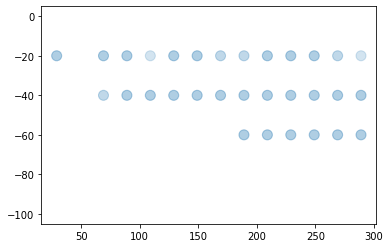

In [ ]:
plt.scatter(df[0], df[1], s=df[4]*100, alpha=0.1)

In [ ]:
df = df[df[4] == 1]

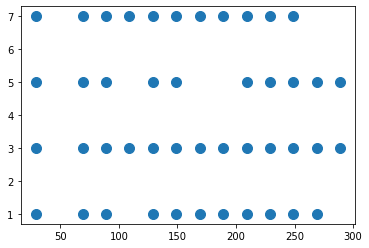

In [ ]:
df2 = df[df[1] == -20]
plt.scatter(df2[0], df2[2], s=100, alpha=1)

# Testing main IR functions

In [1]:
from theia import main
from theia import spec
import cv2
import os
from importlib import reload
reload(main)

loc = spec.LocationInfo()
image_number = 50
files = [f for f in os.listdir('./dataset/sim_dataset/')]
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])
print(files[image_number])
base_dir = os.getcwd()

IMG_160729_071816_0092_RGB.JPG


In [2]:
ir = main.ImageRecognition(base_dir)
ir.image_recognition(image, loc)

2022-01-26 14:54:42,172, [INFO], main , processing image
2022-01-26 14:54:42,492, [INFO], main , ImageRecognitionResult(image_name='c:\\Users\\olive\\Documents\\GitHub\\uas-theia\\runtime\\26012022_14-54-42.240916.jpg', centre=(2310, 3193), position=(0.0, 0.0))


# Experimenting with perspective

In [18]:
ref = read_positions("./dataset/target_positions_transformed")

result = 0
files = [f for f in os.listdir('./dataset/transform_dataset/')]
for image_number in [99]: #range(len(files)):
    image = cv2.imread('./dataset/transform_dataset/' + files[image_number])
    print(files[image_number])

    options = {
        "block_size": 249,
        "c": -39,
        "ksize": 49,
        "sigma": 0,
        "epsilon": 0.02,
        "square_ar": 0.4,
        "min_area": 3000,
    }

    predicted = find_targets(image, options, debug=True)
    if len(predicted) >= 0:
        result+=1
    print(predicted)

print(result/len(files))
print(centre_check(predicted[0], (1316, 2532)))

900-900.jpg
[(1318, 2534), (3707, 288)]
0.01
True


In [33]:
options = {
    "block_size": 249,
    "c": -39,
    "ksize": 49,
    "sigma": 0,
    "epsilon": 0.02,
    "square_ar": 0.4,
    "min_area": 3000,
}
ref = read_positions("./dataset/target_positions_transformed", offset=0)
files = [f for f in os.listdir('./dataset/transform_dataset/')]
results = []
false_positives = []

for file in files:
    image = cv2.imread('./dataset/transform_dataset/' + file)
    result = find_targets(image, options, debug=False)
    try:
        result[0]
        for r in result:
            actual = ref[file]

            if centre_check(r, actual):
                results.append(1)
            else:
                results.append(0)
                false_positives.append(1)

    except Exception as e:
        results.append(0)

print(f"accuracy: {round(sum(results)/len(files) * 100, 2)} %")
print(f"false positives {round(sum(false_positives)/len(results) * 100, 2)} %")
print(f"no. images: {len(files)}")

accuracy: 80.35 %
false positives 13.55 %
no. images: 1557


# other

In [2]:
from theia import position_estimation
from theia.spec import LocationInfo
from theia.image_segmentation import find_targets
from theia.utils import display
import cv2
import os
import math
import geopy.distance
from datetime import datetime
import numpy as np


target_location = (52.7809190, -0.7072140)
directory = r"C:\Users\pm\Downloads\images 2\squares"
files = [f for f in os.listdir(directory)]


image = cv2.imread(directory + "//" + files[0])

src = image
width  = src.shape[1]
height = src.shape[0]

# https://stackoverflow.com/questions/26602981/correct-barrel-distortion-in-opencv-manually-without-chessboard-image

distCoeff = np.zeros((4,1),np.float64)

distCoeff[0,0] = -0.7e-5 # k1
distCoeff[1,0] = 0 # k2
distCoeff[2,0] = 0 # p1
distCoeff[3,0] = 0.0 # p2

# assume unit matrix for camera
cam = np.eye(3,dtype=np.float32)

cam[0,2] = width/2.0  # define center x 
cam[1,2] = height/2.0 # define center y
cam[0,0] = 10        # define focal length x
cam[1,1] = 6        # define focal length y



start_height = 142

options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 1000,
    "sides":[4],
    "debug":False,
    "min_solidity":0.6
}

error_x = []
error_y = []
image_pitch = []
image_roll = []
image_height = []
image_heading = []
image_time = []
total_error=[]
dist_error = []
locations = []

all_data = []

for file in files:
    image = cv2.imread(directory + "//" + file)
    dst = cv2.undistort(image,cam,distCoeff)
    #display(dst)
    predicted = find_targets(dst, options)

    name = file.split(",")
    try:
        l = LocationInfo(lat=float(name[2]), lon=float(name[1]), alt=float(name[0])-start_height,heading=float(name[3]), pitch=float(name[4]), roll=float(name[5]))

        predicted_location = position_estimation.triangulate(predicted[0], l)

        img_time = datetime.utcfromtimestamp(float(name[6].split(".jpg")[0]))
        err = math.sqrt((predicted_location[0]-target_location[0])**2+(predicted_location[1]-target_location[1])**2)
        dist_err = geopy.distance.distance(target_location, predicted_location).m
        if dist_err > 200000:
            print(dist_err)
        # elif img_time.minute < 15:
        #     pass
        else:
            image_pitch.append(l.pitch)
            image_roll.append(l.roll)
            image_height.append(l.alt)
            image_heading.append(l.heading)
            image_time.append(img_time)
            error_x.append(predicted_location[0]-target_location[0])
            error_y.append(predicted_location[1]-target_location[1])
            dist_error.append(dist_err)
            locations.append(predicted_location)
            all_data.append([predicted, l])
            
            total_error.append(math.sqrt((predicted_location[0]-target_location[0])**2+(predicted_location[1]-target_location[1])**2))
            print(dist_err)

    except Exception as e:
        print(e)


41.91470796155282
list index out of range
list index out of range
73.63670807155708
list index out of range
42.863866715971255
64.32787721512048
64.5234258066102
44.30680041204455
list index out of range
49.93219856144053
130.75760680581763
19.99970327585734
list index out of range
199.98082974000653
140.14750354945534
67.03053914076911
36.96044359213419
33.88033024481323
58.09120392393578
140.05389673180463
110.5899687468701
194.50950075916617
130.7075073499072
63.10404454700884
60.690959735178104
43.56742769938298
88.22667277204475
156.36678846798208
51.665983923724625
109.01041400442905
26.04843528633885
27.227772746128444
88.70578862773793
72.3371074716091
90.9789550633099
153.52227689478204
113.24068405947187
list index out of range
38.69925066570396
110.79999501790755
6.346238870268275
list index out of range
66.7530392456694
181.21547897334653
20.318231196659482
8.22966639787523
25.886035328651484
38.42298365328805
49.02719179784161


In [2]:
total_error

[0.0013416132764426196,
 0.0009515800533548564,
 0.0018021649413437883,
 0.0005989241030255072,
 0.0009518018666251184]

In [3]:
import numpy as np
print(np.average(dist_error))

77.54897769886452


In [1]:
l =[(52.78022795106017, -0.7075211631311331), (52.78022707646667, -0.7075216754289068), (52.7802266589004, -0.707522205052959), (52.780227197044894, -0.7075217292275041), (52.780262341478064, -0.7075464685927249), (52.780310148065105, -0.7075935694838444), (52.78035036510439, -0.707640188894831), (52.780400136891366, -0.7076924963729575), (52.780442267835376, -0.7077271012085881), (52.78044233850908, -0.7077303341643213), (52.78044371421573, -0.7077265892469161), (52.780444036068054, -0.7077307791453802), (52.7804448647619, -0.7077454804459459), (52.78044335579589, -0.707726705830543), (52.780443355703284, -0.7077269461865062), (52.7804433127492, -0.7077273502931911), (52.780443265908346, -0.7077282703324562), (52.78044346765382, -0.7077266730760158), (52.780443485437175, -0.7077269874206709), (52.78044352961161, -0.7077281467095357), (52.780440089027536, -0.7077901871553374), (52.78044007943363, -0.7077901802338602), (52.78044005004643, -0.7077897510931044), (52.780440060128036, -0.7077900880245026), (52.780440035743446, -0.7077898235773845), (52.78044001099992, -0.7077897899004341), (52.78043997511639, -0.7077899139340861), (52.78043994496251, -0.7077900842094267), (52.78043907783498, -0.7077952170642098), (52.78043973708489, -0.7077980647823302), (52.780440613912006, -0.7078050058866705), (52.780440963510465, -0.7078021375350623), (52.78043736640403, -0.7077943490075502), (52.78043736102727, -0.7077938303827053), (52.78043729029438, -0.7077935787588088), (52.780437190118036, -0.7077940820812647), (52.78043706104289, -0.7077946648541977), (52.7804370817868, -0.7077925804143511), (52.78043706780877, -0.7077922840359591), (52.78043702349214, -0.7077921367804594), (52.78043699904718, -0.7077916455442851), (52.78043698172955, -0.707792429649338), (52.78043695019784, -0.7077919471671449), (52.780436856533974, -0.7077919030460217), (52.78043684150298, -0.7077927074828547), (52.780435117916674, -0.7077939260502429), (52.780435131167785, -0.7077942068614425), (52.78043517312197, -0.7077943493922467), (52.78043519626061, -0.7077948168259043), (52.7804352121211, -0.7077940694931482), (52.780435242571684, -0.7077945304170724), (52.78043533689258, -0.7077942189002224), (52.78043370829782, -0.7077948066413137), (52.780433717686236, -0.707794956444891), (52.78043374132493, -0.707795031829917), (52.78043375808995, -0.7077952821468624), (52.78043375959881, -0.707794882348498), (52.78043378038744, -0.7077951275109116), (52.78043382481476, -0.707794802775415), (52.78043382783246, -0.7077949609551063), (52.780433829006014, -0.7077947405988764), (52.780432731183396, -0.707794446162926), (52.780432767470195, -0.7077950168713004), (52.7804328585055, -0.7077953034501837), (52.78043292152994, -0.7077962525896475), (52.78043292662282, -0.7077947351912014), (52.78043317426432, -0.7077944326912691), (52.78043318826975, -0.7077957480148616), (52.780433186359915, -0.7077950340170456), (52.78043319017958, -0.707794195100229), (52.78043087347243, -0.7077918336475333), (52.78043096643245, -0.7077932445318377), (52.78043118859113, -0.7077939469592798), (52.78043134615047, -0.7077962803448601), (52.78043135875522, -0.7077925421043956), (52.780428600234515, -0.7077893038556465), (52.78042750617277, -0.7077872449403205), (52.78042751925813, -0.7077873496870619), (52.78042752645788, -0.7077873689117743), (52.780427534678715, -0.7077873701079831), (52.78042756081942, -0.7077873204857444), (52.780427563508624, -0.7077872203755662), (52.78042639614, -0.7077868204415924), (52.78042640407992, -0.707786764399066), (52.78042641248942, -0.7077868317504861), (52.78042641875422, -0.7077867878625773), (52.78042641711495, -0.707786844208485), (52.780426422450645, -0.7077868448818108), (52.78042644098222, -0.7077867485080096), (52.780425873727715, -0.7077865199927692), (52.78042597668656, -0.7077868904548388), (52.7804260391086, -0.7077874015769791), (52.780426160852464, -0.707787662414314), (52.780426174669216, -0.7077871193600408), (52.78042439649879, -0.7077902428617926), (52.780424426346414, -0.7077904939690562), (52.780424495514985, -0.7077900638616996), (52.78042449253649, -0.7077903554091515), (52.78042276350965, -0.7077934602109038), (52.78042277888439, -0.707793641348694), (52.780422787785554, -0.7077936329598085), (52.78042283083482, -0.7077933353097176), (52.78042283180586, -0.7077935366429732), (52.780422831320344, -0.7077936149392392), (52.7804215, -0.7077945), (52.7804215, -0.7077945), (52.7804215, -0.7077945), (52.7804215, -0.7077945), (52.7804215, -0.7077945), (52.78042175808912, -0.707796391136998), (52.780421660925896, -0.7077969906628189), (52.78042154798629, -0.7077968083247181), (52.780421520334514, -0.7077963697015285), (52.78042137925247, -0.7077971029840944), (52.78042138535723, -0.7077966183554717), (52.780420819684785, -0.7077972552563544), (52.78042059508637, -0.7077968900967903), (52.78042053712857, -0.7077960224090477), (52.78042049369464, -0.707796060301922), (52.78042029876958, -0.7077956436300555), (52.78042025968668, -0.7077974818469892), (52.780420274240285, -0.7077965143376099), (52.7804204790399, -0.7077973171785743), (52.780420359170186, -0.7077971171446994), (52.780420333269085, -0.707796641961777), (52.78042018058036, -0.7077969086937811), (52.78042016654837, -0.7077974398516294), (52.780420115565754, -0.7077973601136375), (52.780419497811955, -0.707797873923479), (52.78041947850841, -0.7077977338606547), (52.78041946667033, -0.7077978260179333), (52.78041946805678, -0.7077977078779858), (52.78041945717854, -0.7077977064570586), (52.780419445020506, -0.7077975452833158), (52.78041942219754, -0.7077976542887313), (52.78041942049115, -0.707797908025732), (52.780420102006595, -0.7077972529217895), (52.78042012177045, -0.7077972836091979), (52.78042012069486, -0.7077973582091321), (52.780420127551714, -0.7077973591079265), (52.78042014892894, -0.7077972545909791), (52.7804201496684, -0.7077973919781213), (52.78042015060954, -0.7077972316075226), (52.78042029726332, -0.707798343314885), (52.780420281740284, -0.7077982464158172), (52.78042027552488, -0.7077982454824447), (52.78042025417287, -0.7077983411486113), (52.78042025587945, -0.7077982150905267), (52.780420252264854, -0.7077983620906705), (52.780420683343486, -0.7077986529823455), (52.780420631800226, -0.7077980067743229), (52.780420626323796, -0.7077981765687977), (52.78042058105027, -0.7077984874719666), (52.78042059374882, -0.7077980889999975), (52.78042055685657, -0.7077980842457479), (52.78042044293568, -0.7077979062016607), (52.78042043301709, -0.7077986390219799), (52.780420422623436, -0.7077987614628148), (52.780422581930395, -0.7077989475252585), (52.7804224847758, -0.7077987904627445), (52.78042249719628, -0.7077984120552084), (52.78042246239149, -0.707798406878038), (52.78042235418992, -0.7077982359138708), (52.78042233385286, -0.7077990482956167), (52.78042409301442, -0.7077992891288564), (52.78042408902127, -0.7077991784948816), (52.78042407388465, -0.7077991264771635), (52.78042405795564, -0.7077992329994789), (52.7804240625654, -0.70779909616845), (52.78042404951156, -0.7077990945291183), (52.780424010969114, -0.7077990329283368), (52.78042400351461, -0.7077993256758983), (52.78042472915846, -0.7077986368498644), (52.78042479722457, -0.7077995375094042), (52.78042480736276, -0.7077993036697442), (52.780424872009156, -0.7077988675819705), (52.78042485363491, -0.7077994287085431), (52.78042490599372, -0.7077994363637592), (52.78042493722686, -0.7077994109071287), (52.78042493798012, -0.7078002063842348), (52.78042506514272, -0.7077996876040349), (52.78042507957346, -0.7077986583753505), (52.78042509416983, -0.7077984872105568), (52.78042536387365, -0.7077975477722581), (52.78042528912838, -0.7077980550682381), (52.780425310547635, -0.7077974008853093), (52.78042524773486, -0.7077973930523906), (52.780425254448176, -0.7077965365197307), (52.78042521311376, -0.7077974216392448), (52.780425047251704, -0.7077982956030429), (52.78042502962988, -0.7077984962657087), (52.7804332547103, -0.7077983176038406), (52.78043337603417, -0.707798099141125), (52.780433369903136, -0.7077982553504047), (52.780433408559944, -0.7077981227754546), (52.78043355969258, -0.7077988573742847), (52.78043349999282, -0.70779800037661), (52.780433524324756, -0.707797367252277), (52.780433368393275, -0.7077979049330695), (52.780433555926514, -0.707797769327094), (52.78043357634255, -0.7077972500646166), (52.780433447522334, -0.7077976908771677), (52.78043333443365, -0.7077979142771404), (52.780433978103474, -0.7077978321912224), (52.78043399176975, -0.7077964516373357), (52.780433920977785, -0.7077970196734696), (52.78043394507558, -0.7077964223270592), (52.78043379507725, -0.7077969293372608), (52.780433664759855, -0.7077971897314955), (52.78043440072373, -0.7077971040586676), (52.780434367118175, -0.7077967246151425), (52.780434373250095, -0.7077964447207026), (52.78043430785095, -0.7077966828401174), (52.78043397138534, -0.707794971252561), (52.78043399962857, -0.7077936343876134), (52.780433690547916, -0.70779477072184), (52.7804334162419, -0.707795346422137), (52.78043507293821, -0.7077957792871624), (52.78043496147264, -0.7077945196187623), (52.78043498014586, -0.7077935868221985), (52.780434764738324, -0.7077943826939722), (52.78043557646338, -0.7077942492086798), (52.78043557543632, -0.7077940939882431), (52.78043556831264, -0.7077941581723199), (52.780435569738884, -0.7077940905125909), (52.78043556102872, -0.7077942149772667), (52.78043555413878, -0.7077941481524876), (52.78043586285092, -0.7077929081865767), (52.78043582384228, -0.707793266501128), (52.78043583141967, -0.7077928888050029), (52.78043574435808, -0.7077932098419703), (52.78043566708622, -0.7077933732029185), (52.7804361, -0.7077927), (52.7804361, -0.7077927), (52.7804361, -0.7077927), (52.7804361, -0.7077927), (52.7804361, -0.7077927), (52.78043630195467, -0.7077935958944513), (52.78043630204332, -0.7077935997509349), (52.78043630250878, -0.7077936091449514), (52.78043630381565, -0.7077936043323302), (52.780436304957384, -0.7077936019091682), (52.782684779561336, -0.7129039241577443), (52.781941471536676, -0.7055873915752692), (52.78037281375673, -0.7089515392383179), (52.780364248208436, -0.7089530667605889), (52.7803757806444, -0.7089572263468543), (52.780368990970366, -0.7089556958973918), (52.780370575248725, -0.7089596040614836), (52.78036748091194, -0.708953047506852), (52.780367350077526, -0.7089556102144173), (52.780381174770135, -0.7089615909236311), (52.78036111076893, -0.708951461751806), (52.780366162824926, -0.7089541152130064), (52.78036597261835, -0.7089568652323447), (52.780367937154544, -0.7089585895442367), (52.7803806544063, -0.7089634828254814), (52.78038060159088, -0.7089565065344258), (52.78038082163049, -0.7089565441317706), (52.780380942092656, -0.7089566897431094), (52.780381475929005, -0.7089567178853347), (52.78038092112951, -0.7089569425088378), (52.78038094673082, -0.7089570471655886), (52.78038104162598, -0.7089570878812803), (52.780380570976696, -0.7089582823189743), (52.780380770824415, -0.708958319758207), (52.78038079249274, -0.7089584158285597), (52.78038087827611, -0.70895845476498), (52.78038067680664, -0.7089584739419118), (52.78038136297167, -0.7089584879605965), (52.78037984122622, -0.7089587600065522), (52.78037988872135, -0.7089589709563511), (52.78037805622095, -0.708958303310193), (52.78037856326112, -0.708958399102587), (52.78037861805828, -0.708958641839177), (52.780379331805385, -0.7089575151300106), (52.78037934568005, -0.7089575247253811), (52.78037933459769, -0.7089575275309191), (52.78037940822443, -0.7089575368421814), (52.78037933559254, -0.7089574074648244), (52.78037951911073, -0.7089573736557988), (52.78037949559523, -0.7089573690545644), (52.78037949495703, -0.7089573568760847), (52.78037951435793, -0.7089573520478823), (52.780379180695725, -0.708958372436458), (52.78038094772158, -0.7089580488726354), (52.78038071466749, -0.7089578895451605), (52.780380900873695, -0.7089578419127935), (52.78037955968775, -0.7089578104695681), (52.78038001850917, -0.7089588977879617), (52.78037996588532, -0.70895890743834), (52.780379972641526, -0.7089589087517193), (52.780379972823944, -0.7089589122327585), (52.7803799672815, -0.7089589136349039), (52.7803800071983, -0.7089589146109637), (52.7803794761039, -0.7089590697735211), (52.78037953991682, -0.7089590824875645), (52.78037941686203, -0.7089591643702127), (52.78037942557501, -0.708959294484676), (52.780379420505206, -0.7089592934837814), (52.78037942039698, -0.7089592908895654), (52.78037942455536, -0.7089592898383196), (52.78037876710081, -0.7089593211611397), (52.780378694826474, -0.7089593070327878), (52.78037869287894, -0.7089592698687924), (52.78037875247076, -0.7089592543234555), (52.78037644660408, -0.7089586829876221), (52.780376615532745, -0.7089587153025309), (52.78037648149513, -0.708958837488951), (52.78037748611227, -0.7089588604966767), (52.780376619471234, -0.708958931510279), (52.780378936691385, -0.7089602953844899), (52.780378805085704, -0.7089603099407659), (52.78037883107666, -0.7089603146434257), (52.78037883376611, -0.7089603176898552), (52.780378844608904, -0.7089603172986423), (52.78037883388094, -0.708960326980387), (52.78037891433408, -0.7089603287843168), (52.78037963791639, -0.7089612819234788), (52.780379243688685, -0.708961354124479), (52.78037929410449, -0.7089613641583108), (52.78037925443899, -0.7089614005964641), (52.78037955443836, -0.7089614078902964), (52.78037816453494, -0.7089608916726452), (52.780378181559406, -0.7089609112025551), (52.780378250140785, -0.7089609087426484), (52.78037818234045, -0.7089609710099893), (52.780378692155935, -0.7089609825812575), (52.78037699706381, -0.708959931395806), (52.78037721411014, -0.708959974518566), (52.780377042141495, -0.7089601312514956), (52.78037787340323, -0.7089600900905665), (52.780377663011436, -0.7089601285723716), (52.78037769021144, -0.7089601338994065), (52.78037766875085, -0.7089601534162406), (52.78037769129407, -0.7089601686720465), (52.7803777, -0.7089602), (52.7803777, -0.7089602), (52.7803777, -0.7089602), (52.7803777, -0.7089602), (52.7803777, -0.7089602), (52.7803777, -0.7089602), (52.7803777, -0.7089602), (52.78037770846901, -0.7089600609756201), (52.780377821043906, -0.7089600503553244), (52.78037781173192, -0.7089600100804182), (52.78037652107691, -0.7089601398758166), (52.78037652823664, -0.7089601477875114), (52.78037655650844, -0.7089601463945966), (52.78037655715595, -0.7089601639919657), (52.780376528791834, -0.7089601724016602), (52.78037655830925, -0.7089601916020953), (52.78037669032101, -0.7089601739664141), (52.780376472121674, -0.7089601947895616), (52.78037649100155, -0.7089602721997822), (52.78037704527888, -0.7089609127718934), (52.780377014679786, -0.7089609193022582), (52.780375809718024, -0.7089601635129436), (52.78037582285206, -0.7089602164081614), (52.78037614177779, -0.7089602524663405), (52.78037454611491, -0.7089587166258358), (52.78037448763615, -0.708958801761796), (52.78037452999601, -0.7089588405145456), (52.78037452596308, -0.7089589671336343), (52.78037467319081, -0.7089596599028465), (52.78037470367632, -0.7089597914751059), (52.7803748266195, -0.7089598698087609), (52.78037550300185, -0.7089598806195879), (52.78037506314766, -0.7089597299604495), (52.78037506904293, -0.7089597548380587), (52.780375092042476, -0.7089597696146425), (52.78037521953037, -0.7089597716521484), (52.78037441700038, -0.7089599321751539), (52.780374494722004, -0.7089599451811689), (52.78037450376939, -0.7089599822327718), (52.78037307422446, -0.7089599720745903), (52.78037352620771, -0.7089600326570955), (52.78037229624035, -0.7089603412296003), (52.78037227507815, -0.7089603712351374), (52.78037228907364, -0.7089604302658531), (52.78037235051397, -0.708960477315312), (52.780372646769784, -0.7089604703320589), (52.7803725489086, -0.7089598767842527), (52.7803725639928, -0.7089599400894451), (52.780372950319155, -0.7089599833667757), (52.78037627519721, -0.7089614556507416), (52.78037634992699, -0.7089613483831323), (52.78037629930461, -0.7089611411366145), (52.78037473174927, -0.7089613149522733), (52.780374734689225, -0.7089613273568844), (52.78037461227694, -0.7089608410226655), (52.780374620378396, -0.7089608752416489), (52.7803746559269, -0.7089609025193448), (52.78037398220715, -0.7089599637351766), (52.78037403716008, -0.7089601843514785), (52.78037537306922, -0.7089603335657788), (52.7803757626882, -0.7089573647145729), (52.78037575534513, -0.7089573353097441), (52.78037572478105, -0.7089573115461154), (52.78037557647466, -0.7089573152572345), (52.780374868805026, -0.7089552500050829), (52.780374879260215, -0.7089552920822015), (52.78037492268209, -0.7089553256955056), (52.78037513317151, -0.7089553202882015), (52.78037756405443, -0.7089569999729742), (52.780377543615096, -0.7089569159105988), (52.78037703353001, -0.7089568594908487), (52.78037784422864, -0.7089567486422989), (52.780377678425495, -0.7089566203270151), (52.78037687170119, -0.7089566394718179), (52.780377363914454, -0.7089568319889065), (52.78037733153169, -0.7089568069890645), (52.780377792459525, -0.7089571516911519), (52.78037791232513, -0.7089572442205815), (52.7803786029094, -0.7089578355567122), (52.780377567778714, -0.7089579356710328), (52.780377659596965, -0.7089583055231412), (52.780378043105756, -0.7089586021664305), (52.780379152090454, -0.708958017954752), (52.780379176263544, -0.7089581175112258), (52.78037956332095, -0.7089583714191312), (52.78038079867153, -0.7089581282050914), (52.78038076269509, -0.708957984249076), (52.780379887312584, -0.7089579776649779), (52.780379492951226, -0.7089568793731962), (52.780379545527474, -0.7089568686861425), (52.78037947796845, -0.7089568749264279), (52.78037953923323, -0.7089568418430485), (52.7803795265909, -0.7089568099493446), (52.780379651397816, -0.7089554246137993), (52.78037948881436, -0.7089554394086572), (52.780379635904644, -0.7089553608497532), (52.780379163514915, -0.7089553582645224), (52.78037976413368, -0.7089553009634181), (52.78037987399641, -0.70895427717028), (52.780379849303785, -0.7089541729437236), (52.780379077595526, -0.7089541687112173), (52.78037997460852, -0.708955241500811), (52.780379962503034, -0.7089551915523544), (52.78037991948831, -0.708955171034353), (52.78037991676216, -0.7089551617789078), (52.78037966078844, -0.708955158114099), (52.780380707069554, -0.708957630925331), (52.780380610793564, -0.7089576403545411), (52.78038061931233, -0.7089576744445896), (52.780380654980846, -0.7089577019785425), (52.78038123489349, -0.7089592010291965), (52.780381385115255, -0.7089592709880493), (52.78038116223662, -0.7089592925452753), (52.780381182007524, -0.7089593721954908)]

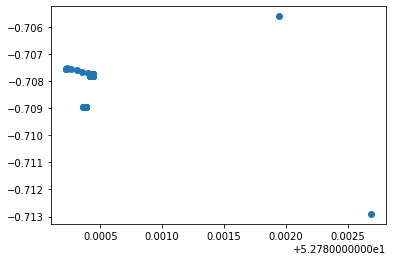

In [3]:
import matplotlib.pyplot as plt
plt.scatter([a[0] for a in l], [a[1] for a in l])

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np

print(sum(error_x)/len(error_x))
print(sum(error_y)/len(error_y))

total_error=[]
for i in range(len(error_x)):
    total_error.append(math.sqrt(error_x[i]**2+error_y[i]**2))

plt.figure(0)
plt.scatter(error_x,error_y)
plt.grid()
plt.xlabel("error in x")
plt.ylabel("error in y")

plt.figure(1)
plt.scatter(image_pitch,dist_error)
plt.grid()
plt.xlabel("pitch")
plt.ylabel("error (m)")

plt.figure(2)
plt.scatter(image_roll,dist_error)
plt.grid()
plt.xlabel("roll")
plt.ylabel("error (m)")


plt.figure(3)
plt.scatter(image_roll, image_pitch, c=dist_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("roll")
plt.ylabel("pitch")

roll_pitch=[]
for i in range(len(error_x)):
    roll_pitch.append(math.sqrt(image_pitch[i]**2+image_roll[i]**2))

plt.figure(4)
plt.scatter(image_height,roll_pitch,c=dist_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("height")
plt.ylabel("roll_pitch")

plt.figure(5)
plt.scatter(image_time,dist_error,c=image_height, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("image time")
plt.ylabel("error (m)")

plt.figure(6)
plt.scatter(image_time,image_height,c=dist_error, cmap='viridis')
plt.grid()
plt.colorbar()
plt.xlabel("time")
plt.ylabel("height")

plt.figure(7)
plt.scatter(image_height, dist_error)
plt.xlabel("height (m)")
plt.ylabel("error (m)")
plt.grid()


In [38]:
plt.figure(8)
import pandas as pd
import seaborn as sns
df = pd.DataFrame.from_dict(np.array([image_pitch,image_roll,dist_error]).T)
df.columns = ['x','y','z']
df['z'] = pd.to_numeric(df['z'])
pivotted= df.pivot('y','x','z')

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_xlabel('image_pitch')
ax.set_ylabel('image_roll')
ax.set_zlabel('dist_error')
plt.grid()
#ax.plot_wireframe(cParams, gammas, avg_errors_array)
#ax.plot3D(cParams, gammas, avg_errors_array)
#ax.scatter3D(cParams, gammas, avg_errors_array, zdir='z',cmap='viridis')

surf = ax.plot_trisurf(df.x, df.y, df.z, cmap='viridis', linewidth=0.1)
ax.view_init(azim=0, elev=90)
fig.colorbar(surf, shrink=0.5, aspect=10)    
plt.show()


In [ ]:
class RLS:
    def __init__(self, num_vars, lam, delta):
        '''
        num_vars: number of variables including constant
        lam: forgetting factor, usually very close to 1.
        '''
        self.num_vars = num_vars
        
        # delta controls the initial state.
        self.A = delta*np.matrix(np.identity(self.num_vars))
        self.w = np.matrix(np.zeros(self.num_vars))
        self.w = self.w.reshape(self.w.shape[1],1)
        
        # Variables needed for add_obs
        self.lam_inv = lam**(-1)
        self.sqrt_lam_inv = math.sqrt(self.lam_inv)
        
        # A priori error
        self.a_priori_error = 0
        
        # Count of number of observations added
        self.num_obs = 0

    def add_obs(self, x, t):
        '''
        Add the observation x with label t.
        x is a column vector as a numpy matrix
        t is a real scalar
        '''            
        z = self.lam_inv*self.A*x
        alpha = float((1 + x.T*z)**(-1))
        self.a_priori_error = float(t - self.w.T*x)
        self.w = self.w + (t-alpha*float(x.T*(self.w+t*z)))*z
        self.A -= alpha*z*z.T
        self.num_obs += 1
        
    def fit(self, X, y):
        '''
        Fit a model to X,y.
        X and y are numpy arrays.
        Individual observations in X should have a prepended 1 for constant coefficient.
        '''
        for i in range(len(X)):
            x = np.transpose(np.matrix(X[i]))
            self.add_obs(x,y[i])


    def get_error(self):
        '''
        Finds the a priori (instantaneous) error. 
        Does not calculate the cumulative effect
        of round-off errors.
        '''
        return self.a_priori_error
    
    def predict(self, x):
        '''
        Predict the value of observation x. x should be a numpy matrix (col vector)
        '''
        return float(self.w.T*x)

In [66]:
import numpy as np
import matplotlib.pylab as plt
import padasip as pa

# creation of data
dfx = df[["lat", "lon", "px", "py", "alt", "roll", "pitch", "heading"]]
dfy = df[["est_lat2", "est_lon2"]]
x = dfx.to_numpy()
y = dfy.to_numpy()

LS = RLS(8,0.99,1)
# Not using the RLS.fit function because I want to remember all the predicted values
pred_x = []
pred_y = []
for i in range(20):
    LS.add_obs(np.matrix(x[i]),y[i])
print(LS.w)
# plot the predicted values against the non-noisy output
ax = plt.plot(pred_x, y-pred_y)
plt.show()

ValueError: shapes (8,8) and (1,8) not aligned: 8 (dim 1) != 1 (dim 0)

[[-4.94322404]
 [-3.80064484]
 [ 0.20000058]]


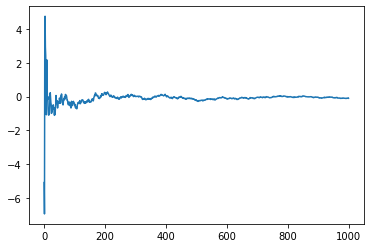

In [59]:
test_size = 1000
# Test function
f = lambda x: 0.2*x**2-3.8*x-5.1
# Gaussian noise to be added to the quadratic signal
noise = np.random.randn(test_size)
# You can play around with other noise (like sinusoidal)
#noise = [np.sin(2*np.pi*i/13) for i in range(test_size)]
y = np.array([f(i) for i in range(test_size)])
noisy_y = y + noise
lam = 0.98
LS = RLS(3,lam,1)
# Not using the RLS.fit function because I want to remember all the predicted values
pred_x = []
pred_y = []
for i in range(test_size):
    x = np.matrix(np.zeros((1,3)))
    x[0,0] = 1
    x[0,1] = i
    x[0,2] = i**2
    pred_x.append(i)
    pred_y.append(float(x*LS.w))
    LS.add_obs(x.T,noisy_y[i])
print(LS.w)
# plot the predicted values against the non-noisy output
ax = plt.plot(pred_x, y-pred_y)
plt.show()

In [65]:
x

matrix([[1.00000e+00, 9.99000e+02, 9.98001e+05]])

In [9]:
from ipyleaflet import (
    Map,
    Marker,
    MarkerCluster,
    TileLayer,
    ImageOverlay,
    Polyline,
    Polygon,
    Rectangle,
    Circle,
    CircleMarker,
    Popup,
    GeoJSON,
    DrawControl,
    basemaps,
    AwesomeIcon
)

from ipywidgets import HTML, Layout

target_location = [52.78042455, -0.70778441]
zoom = 100

m = Map(basemap=basemaps.Esri.WorldImagery, center=target_location, zoom=zoom, layout=Layout(width='800px', height='800px'))
m.add_layer(
    CircleMarker(location=target_location, radius=20)
)
m.add_layer(
    MarkerCluster(markers=[
        Marker(location=loc) for loc in l
    ],
    disable_clustering_at_zoom=3)
)

m

Map(center=[52.78042455, -0.70778441], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_tit…

Text(0, 0.5, 'pitch')

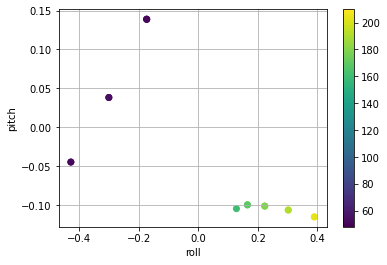

In [8]:
plt.figure(3)
plt.scatter(image_roll, image_pitch, c=dist_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("roll")
plt.ylabel("pitch")

In [9]:
import pandas as pd
import numpy as np
df = [{ 
    "px":row[1][0][0][0], 
    "py": row[1][0][0][1], 
    "lat": row[1][1].lat,
    "lon": row[1][1].lon,
    "alt": row[1][1].alt,
    "roll": row[1][1].roll,
    "pitch": row[1][1].pitch,
    "heading": row[1][1].heading
} for row in enumerate(all_data)]
df.append({
    "px":1920/2, 
    "py": 1080/2, 
    "lat": target_location[0],
    "lon": target_location[1],
    "alt": 100,
    "roll": 0.4,
    "pitch": 0.4,
    "heading": 350
})
df = pd.DataFrame(df)


ModuleNotFoundError: No module named 'pandas'

In [7]:
import pyproj
import math
geodesic = pyproj.Geod(ellps='WGS84')
df["bearing_act"] = df.apply(lambda row: geodesic.inv(target_location[0], target_location[1], row.lat, row.lon)[0], axis=1)
df["distance_act"] = df.apply(lambda row: geodesic.inv(target_location[0], target_location[1], row.lat, row.lon)[2], axis=1)
df["anglez_act"] = df.apply(lambda row: math.degrees(math.atan(row.distance_act/row.alt)), axis=1)

RESOLUTION = np.array([1080, 1920]) # px
ASPECT_RATIO = RESOLUTION[1]/RESOLUTION[0]
SENSOR_W = 6.4 #mm
SENSOR_H = SENSOR_W / ASPECT_RATIO #mm
LENS_F = 6 #mm
FOV_X = 2 * math.atan2(SENSOR_W/2, LENS_F)
FOV_Y = 2 * math.atan2(SENSOR_H/2, LENS_F)
print(FOV_X, FOV_Y)

sin_rule = lambda alpha, a, b: math.asin(b * math.sin(alpha)/a)
# calculate angle of point in FOV
df["fov_angle_x"] = df.apply(lambda row: sin_rule((math.pi/2 - FOV_X)/2, 915.1, row.px) - FOV_X/2, axis=1)
df["fov_angle_y"] = df.apply(lambda row: sin_rule((math.pi/2 - FOV_Y)/2, 578.90595, row.py) - FOV_Y/2, axis=1)
# caculate the distance offset
df["offset_x"] = df.apply(lambda row: math.tan(row.fov_angle_x + row.roll) * row.alt, axis=1)
df["offset_y"] = df.apply(lambda row: math.tan(row.fov_angle_y + row.pitch) * row.alt, axis=1)
# rotate points to account for heading
df["Px"] = df.apply(lambda row: row.offset_x * math.cos(math.radians(-row.heading)) - row.offset_y * math.sin(math.radians(-row.heading)), axis=1)
df["Py"] = df.apply(lambda row: row.offset_x * math.sin(math.radians(-row.heading)) + row.offset_y * math.cos(math.radians(-row.heading)), axis=1)
# convert from meters to lat lon
df["est_lat"] = df.apply(lambda row: row.lat + row.Px/111320, axis=1)
df["est_lon"] = df.apply(lambda row: row.lon + row.Py/((40075000 * math.cos(math.radians(row.lat))) / 360), axis=1)

df["distance_error"] = df.apply(lambda row: geopy.distance.distance(target_location, (row.est_lat,row.est_lon)).m, axis=1)
df["bearing_est"] = df.apply(lambda row: geodesic.inv(row.est_lat, row.est_lon, row.lat, row.lon)[0], axis=1)
df["distance_est"] = df.apply(lambda row: geodesic.inv(row.est_lat, row.est_lon, row.lat, row.lon)[2], axis=1)
df["anglez_est"] = df.apply(lambda row: math.degrees(math.atan(row.distance_est/row.alt)), axis=1)

df["est_lat2"] = df.apply(lambda row: position_estimation.triangulate((row.px, row.py), LocationInfo(lat=row.lat, lon=row.lon, alt=row.alt, heading=row.heading, pitch=row.pitch, roll=row.roll))[0], axis=1)
df["est_lon2"] = df.apply(lambda row: position_estimation.triangulate((row.px, row.py), LocationInfo(lat=row.lat, lon=row.lon, alt=row.alt, heading=row.heading, pitch=row.pitch, roll=row.roll))[1], axis=1)

df["distance_error2"] = df.apply(lambda row: geopy.distance.distance(target_location, (row.est_lat2,row.est_lon2)).m, axis=1)
df["bearing_est2"] = df.apply(lambda row: geodesic.inv(row.est_lat2, row.est_lon2, row.lat, row.lon)[0], axis=1)
df["distance_est2"] = df.apply(lambda row: geodesic.inv(row.est_lat2, row.est_lon2, row.lat, row.lon)[2], axis=1)
df["anglez_est2"] = df.apply(lambda row: math.degrees(math.atan(row.distance_est2/row.alt)), axis=1)


ModuleNotFoundError: No module named 'pyproj'

In [6]:
coords = [(lat, lon) for lat,lon in zip(df.est_lat, df.est_lon)]

from ipyleaflet import (
    Map,
    Marker,
    MarkerCluster,
    TileLayer,
    ImageOverlay,
    Polyline,
    Polygon,
    Rectangle,
    Circle,
    CircleMarker,
    Popup,
    GeoJSON,
    DrawControl,
    basemaps,
    AwesomeIcon
)

from ipywidgets import HTML, Layout

center = [34.6252978589571, -77.34580993652344]
zoom = 100

m = Map(basemap=basemaps.Esri.WorldImagery, center=target_location, zoom=zoom, layout=Layout(width='800px', height='800px'))
m.add_layer(
    CircleMarker(location=target_location, radius=20)
)
m.add_layer(
    MarkerCluster(markers=[
        Marker(location=loc) for loc in coords
    ],
    disable_clustering_at_zoom=3)
)

avg = [sum(x)/len(x) for x in zip(*coords)]
icon = AwesomeIcon(marker_color="red")

m.add_layer(
    Marker(location=avg, color="red", icon=icon)
)

m

NameError: name 'df' is not defined

Text(0, 0.5, 'distance_est')

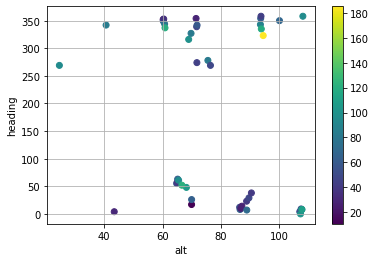

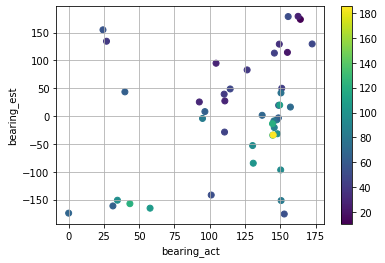

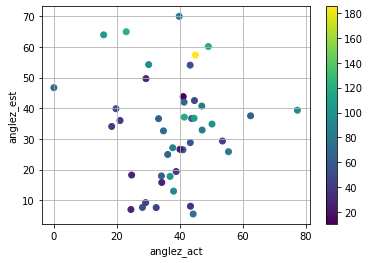

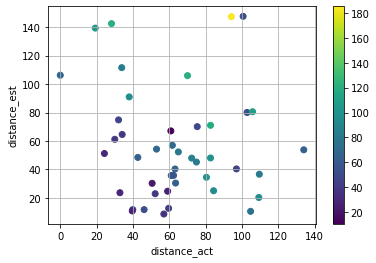

In [179]:
import matplotlib.pyplot as plt
plt.figure(10)
plt.scatter(df.alt, df.heading, c=df.distance_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("alt")
plt.ylabel("heading")

plt.figure(11)
plt.scatter(df.bearing_act, df.bearing_est, c=df.distance_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("bearing_act")
plt.ylabel("bearing_est")

plt.figure(12)
plt.scatter(df.anglez_act, df.anglez_est, c=df.distance_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("anglez_act")
plt.ylabel("anglez_est")

plt.figure(13)
plt.scatter(df.distance_act, df.distance_est, c=df.distance_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("distance_act")
plt.ylabel("distance_est")

Text(0, 0.5, 'pitch')

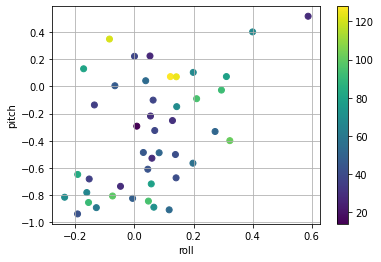

In [148]:
plt.figure(3)
plt.scatter(df.roll, df.pitch, c=df.distance_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("roll")
plt.ylabel("pitch")

tried morphology, reduces noise but increases processing time by ~5%. doesn't seem to affect accuracy.
https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html

tried CLACHE - no noticeable accuracy increase

tried making C more negative - reduces noise and chance of identifying target

In [4]:
directory = r"C:\Users\olive\University of Surrey\UAS2 - General\2 Avionics\4 Testing\Image Rec\10_04_22\squares"
files = [f for f in os.listdir(directory)]


options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 1000,
    "sides":[4],
    "min_solidity": 0.6,
    "debug":True
}

results = 0
false_positives = []

for file in files:
    image = cv2.imread(directory + "//" + file)
    result = find_targets(image, options)
    try:
        result[0]
        results+=1
    except KeyboardInterrupt:
        raise Exception()
    except Exception:
        #find_targets(image, options)
        pass

print(results/len(files))
print(results)
print(len(files))


0.7666666666666667
23
30


In [ ]:
directory = r"C:\Users\olive\University of Surrey\UAS2 - General\2 Avionics\4 Testing\Image Rec\03_04_22\square"
image_number = 23
files = [f for f in os.listdir(directory)]
image = cv2.imread(directory + "//" + files[image_number])

options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 1000,
    "sides":[4],
    "debug":False
}

imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
display(imgGray)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(imgGray)
display(cl1)
imgBlurred = cv2.GaussianBlur(cl1, (59,59),0)
# laplacian = cv2.Laplacian(cv2.bitwise_not(imgBlurred),cv2.CV_64F)
# display(laplacian)
img_thresh = cv2.adaptiveThreshold(
    imgBlurred,
    255,
    cv2.ADAPTIVE_THRESH_MEAN_C, 
    cv2.THRESH_BINARY,
    399,
    -69
)
display(img_thresh)

contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
squareIndexes = filterContours(contours, options)

for index in squareIndexes:
    cv2.drawContours(image, contours[index], -1, (0, 255, 0), 3)
display(image)

In [4]:
import numpy as np

src = image
width  = src.shape[1]
height = src.shape[0]

# https://stackoverflow.com/questions/26602981/correct-barrel-distortion-in-opencv-manually-without-chessboard-image

distCoeff = np.zeros((4,1),np.float64)

distCoeff[0,0] = -0.7e-5 # k1
distCoeff[1,0] = 0 # k2
distCoeff[2,0] = 0 # p1
distCoeff[3,0] = 0.0 # p2

# assume unit matrix for camera
cam = np.eye(3,dtype=np.float32)

cam[0,2] = width/2.0  # define center x 
cam[1,2] = height/2.0 # define center y
cam[0,0] = 10        # define focal length x
cam[1,1] = 6        # define focal length y


image = cv2.imread(directory + "//" + files[3])

dst = cv2.undistort(image,cam,distCoeff)

numpy_vertical = np.vstack((image, dst))

width  = dst.shape[1]
height = dst.shape[0]
print(width, height)

display(numpy_vertical)

1920 1080


In [1]:
import numpy as np
import cv2 as cv
from theia.image_segmentation import find_targets

directory = r"C:\Users\pm\Downloads\images 2"
files = [f for f in os.listdir(directory)]

for image_number in range(0,len(files)):
    image = cv.imread(directory + "/" + files[image_number])

    options = {
            "block_size": 399,
            "c": -39,
            "ksize": 39,
            "sigma": 0,
            "epsilon": 0.1,
            "min_area": 1000,
            "sides":[4],
            "min_solidity": 0.6,
            "debug": True
    }
    print(find_targets(image,options))




[]
[]
[]
[]
[]
[]
[]
[]
[]
[(52, 741)]
[]
[]
[]
[]
[(348, 354)]
[(343, 123)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(1038, 91)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(39, 777)]
[(356, 1018), (164, 641)]
[(410, 913)]
[(346, 994)]
[(1089, 974)]
[(39, 1057), (553, 991), (1154, 860)]
[(93, 1038), (617, 919), (1210, 765)]
[(152, 1008), (672, 853), (1019, 598)]
[(54, 694), (677, 387), (162, 205)]
[(1419, 439), (621, 255), (120, 93)]
[(557, 90), (539, 20)]
[(528, 819), (36, 374), (720, 283), (258, 237), (500, 39)]
[(503, 649), (27, 204), (706, 116), (247, 63)]
[(509, 533), (163, 243)]
[(490, 432), (152, 141)]
[(107, 785), (463, 366), (137, 75)]
[(30, 629), (372, 317)]
[(310, 264)]
[]
[]
[]
[]
[]
[]
[]
[]